# 03. Training and Test

Train and test different unsupervised approaches to detect flight anomalies.

## 01. Imports and Settings

In [1]:
# Imports
from libs.anomaly_clf import (
    Autoencoder,
    OneClassSVMWrapper,
    LocalOutlierFactorWrapper,
    IsolationForestWrapper
)  # anomaly_clf.py
from libs.model_evaluation import test_model  # model_evaluation.py
from libs.pre_process import scaler_data  # pre_process.py
from libs.plots import show_scatterplot  # plots.py
from libs.utils import (
    split_X_y,
    split_train_test,
    save_object,
    load_object
)  # utils.py

import pandas as pd
import warnings


# Ignore warnings
warnings.filterwarnings("ignore")

# Pandas settings
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 150)  # Increase column width

# Default path
DATA_PATH = "data/"
BIN_PATH = "bin/"

## 02. Load and Pre-Process Data

In [2]:
# Load Jamming and Spoofing flight data
jamming_flight_df = pd.read_csv(f"{DATA_PATH}jamming_flight_preprocessed.csv")
spoofing_flight_df = pd.read_csv(f"{DATA_PATH}spoofing_flight_preprocessed.csv")
# Convert date columns to Pandas Datetime
jamming_flight_df["DateTime"] = pd.to_datetime(jamming_flight_df["DateTime"])
spoofing_flight_df["DateTime"] = pd.to_datetime(spoofing_flight_df["DateTime"])

# Split train and test data
train_df, test_df = split_train_test(jamming_flight_df, target_column="is_target", test_size=0.20)
# Split into X and y
X_train, y_train = split_X_y(train_df, "is_target", ["DateTime"])
X_test, y_test = split_X_y(test_df, "is_target", ["DateTime"])
# Spoofing flight data
X_spoofing, y_spoofing = split_X_y(spoofing_flight_df, "is_target", ["DateTime"])

In [3]:
# Scale training data
X_train_norm, scaler = scaler_data(X_train)
# Save scale object...
save_object(scaler, f"{BIN_PATH}scaler_obj")

# Load scale object...
scaler = load_object(f"{BIN_PATH}scaler_obj")
# Scale test data
X_test_norm, _ = scaler_data(X_test, scaler)
# And Spoofing flight data
X_spoofing_norm, _ = scaler_data(X_spoofing, scaler)

## 03. Training and Test

In [4]:
# Dictionary to save models and their metrics
models = dict()

# Initializing for each classifier
for clf in ["autoencoder", "oc_svm", "lof", "iforest"]:
    models[clf] = {"obj": object(), "metrics": {}}

### 03.1. Autoencoder

In [5]:
# Instantiate autoencoder
models["autoencoder"]["obj"] = Autoencoder(X_train_norm, y_train)
# Generate autoencoder model
models["autoencoder"]["obj"].create_model()

In [6]:
# Model training...
_, _, _ = models["autoencoder"]["obj"].fit_model(verbose=1)
# Save autoencoder object...
save_object(models["autoencoder"]["obj"], f"{BIN_PATH}autoencoder_obj")

Epoch 1/100
15/15 [==============================] - 1s 2ms/step - loss: 0.1824
Epoch 2/100
15/15 [==============================] - 0s 1ms/step - loss: 0.1644
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 0.1246
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 0.0794
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0484
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0356
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0342
Epoch 9/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 10/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0317
Epoch 11/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 12/100
15/15 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 13/100
15/15 [=================

#### Reconstrunction Error

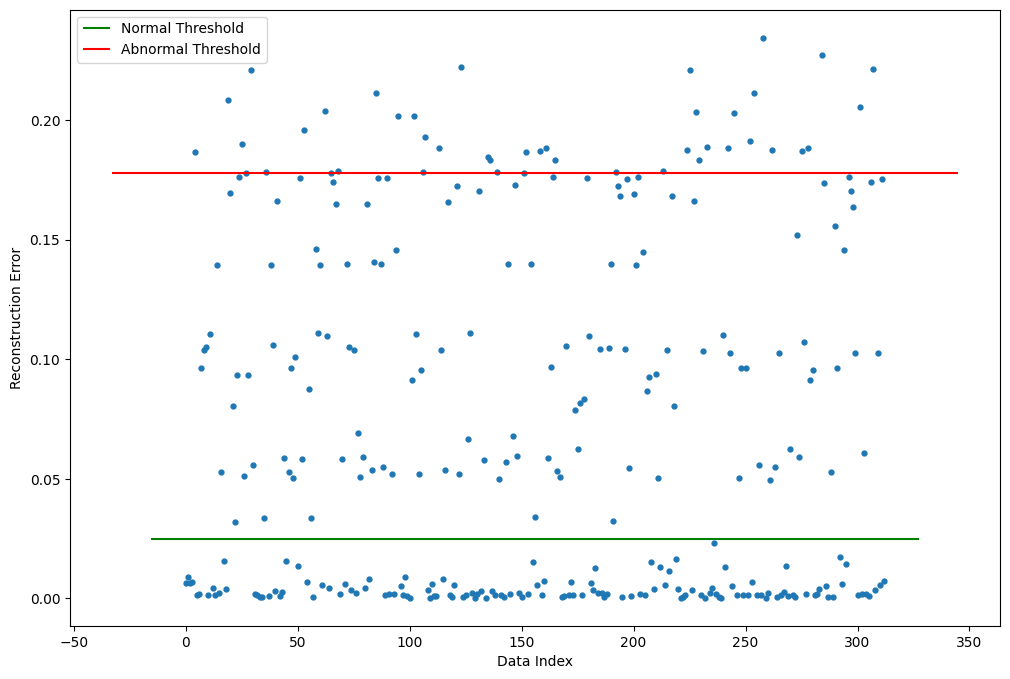

In [7]:
_ = models["autoencoder"]["obj"].plot_reconstrunction_error(X_test_norm)

#### Evaluate Model

Model Test: {'Precision': '100.0', 'Recall': '86.89', 'F1': '92.98', 'ROC_AUC': '93.44', 'Log_Loss': '2.7637'}



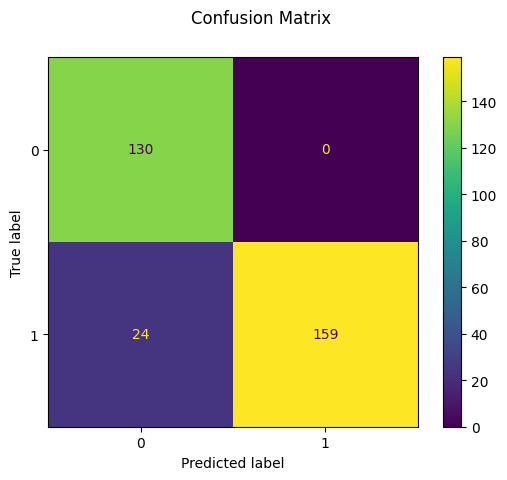

In [8]:
# Evaluating...
models["autoencoder"]["metrics"] = test_model(models["autoencoder"]["obj"], X_test_norm.values, y_test)

#### Test on Spoofing Flight Data

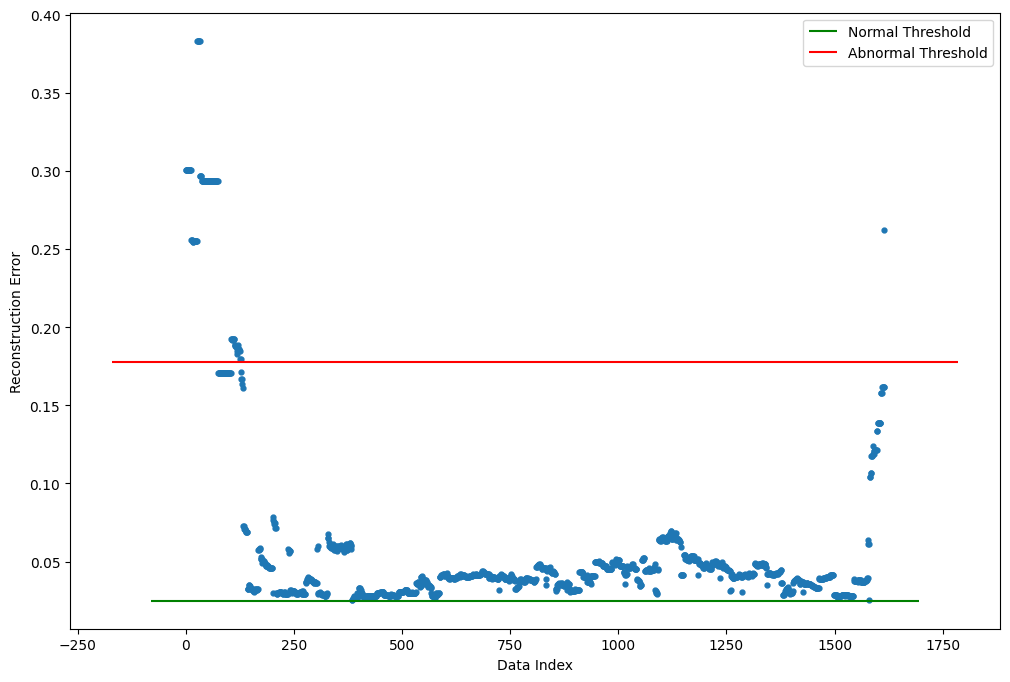

In [9]:
# Reconstrunction error...
_ = models["autoencoder"]["obj"].plot_reconstrunction_error(X_spoofing_norm)

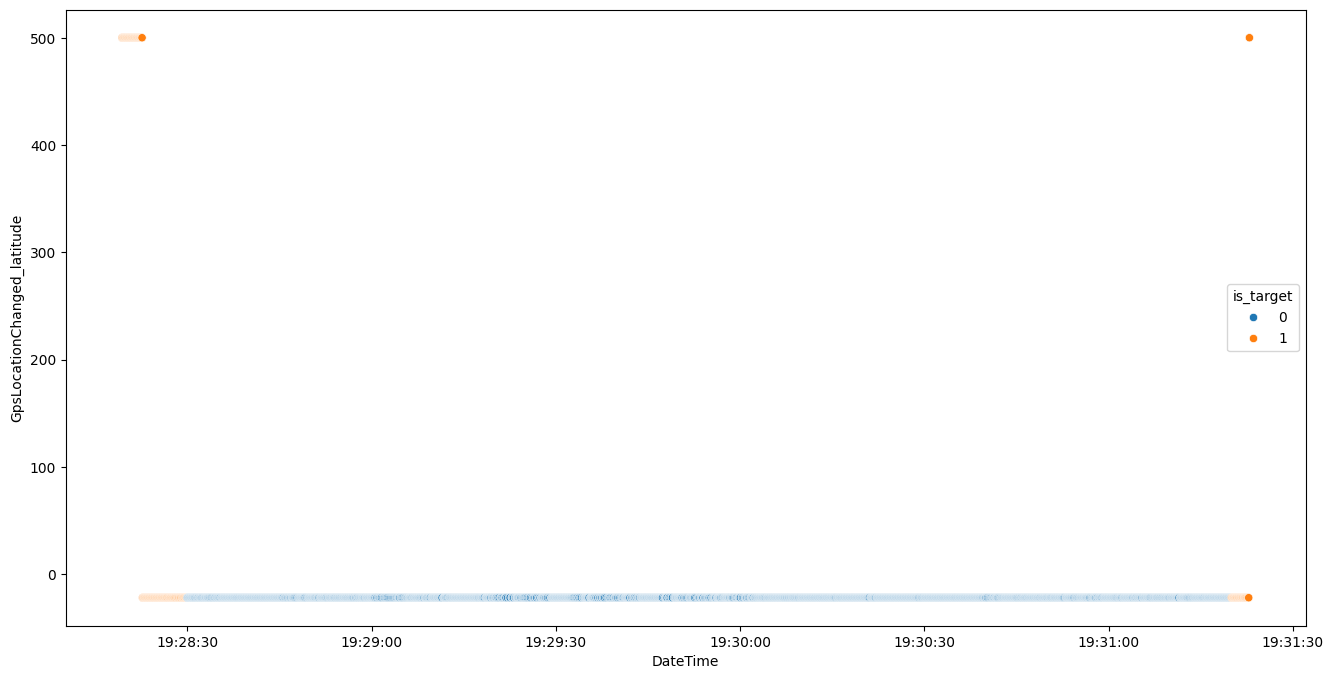

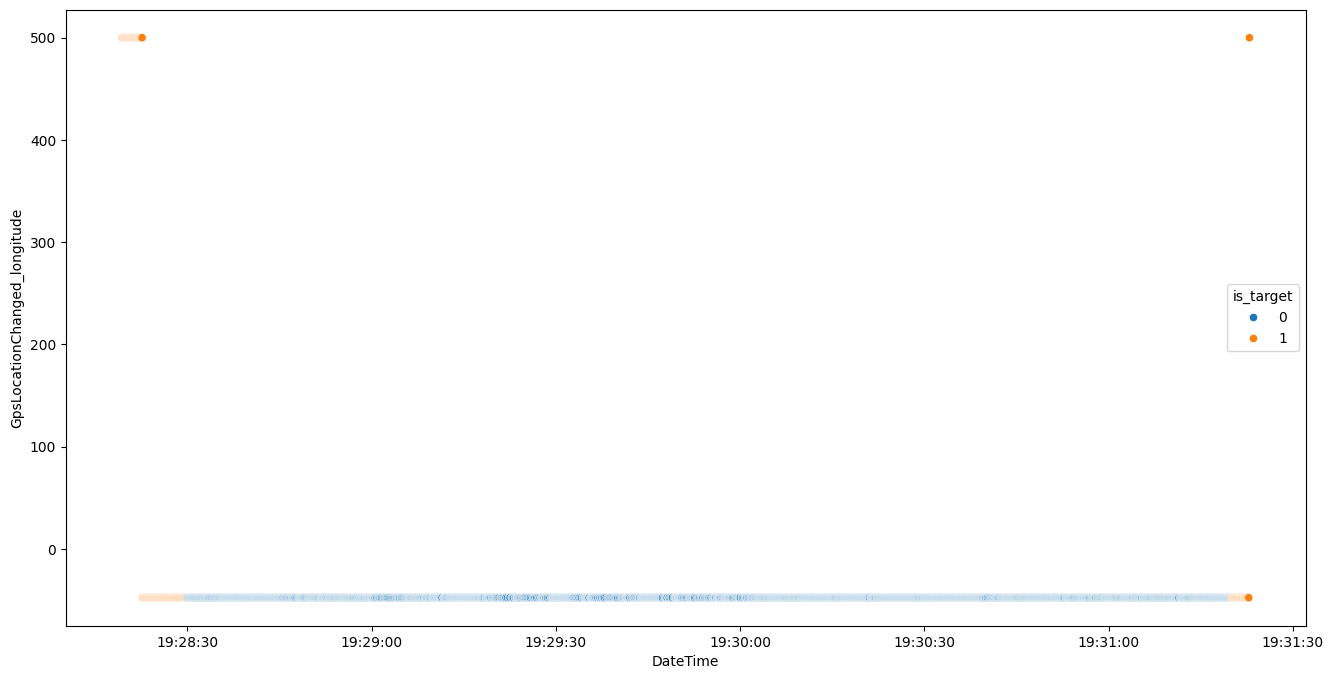

In [10]:
# Latitude and Longitude in Spoofing data
# Biggest reconstruction errors are coinciding with the instant of the threat
show_scatterplot(spoofing_flight_df, "DateTime", "GpsLocationChanged_latitude", category="is_target");
show_scatterplot(spoofing_flight_df, "DateTime", "GpsLocationChanged_longitude", category="is_target")

Model Test: {'Precision': '18.01', 'Recall': '100.0', 'F1': '30.52', 'ROC_AUC': '80.08', 'Log_Loss': '13.2041'}



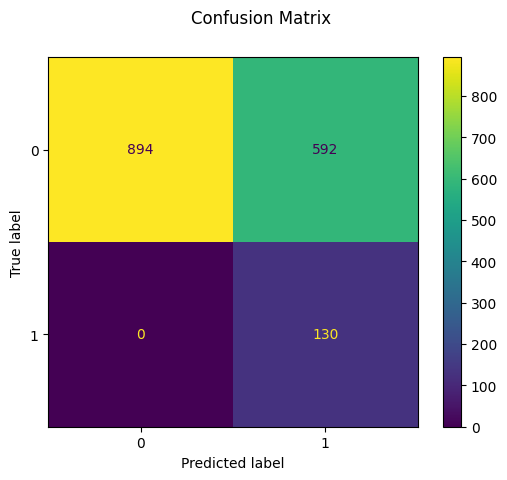

In [11]:
# Evaluating...
_ = test_model(models["autoencoder"]["obj"], X_spoofing_norm.values, y_spoofing)

### 03.2. One-Class SVM (OC-SVM)

In [12]:
# Fit OC-SVM
models["oc_svm"]["obj"] = OneClassSVMWrapper().fit(X_train_norm[y_train == 0].values)
# Save OC-SVM object...
save_object(models["oc_svm"]["obj"], f"{BIN_PATH}oc_svm_obj")

#### Evaluate Model

Model Test: {'Precision': '72.05', 'Recall': '100.0', 'F1': '83.75', 'ROC_AUC': '72.69', 'Log_Loss': '8.176'}



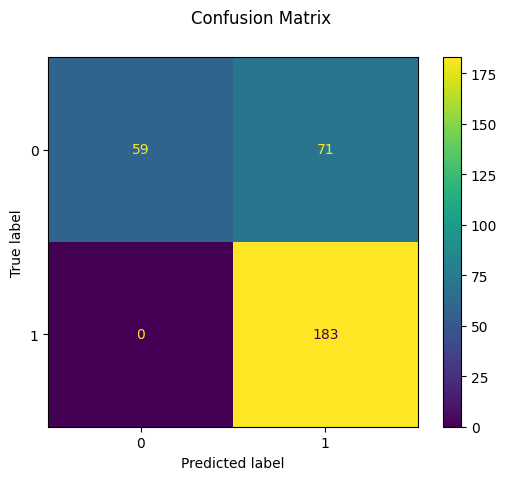

In [13]:
# Evaluating...
models["oc_svm"]["metrics"] = test_model(models["oc_svm"]["obj"], X_test_norm.values, y_test)

### 03.3. Local Outlier Factor (LOF)

In [14]:
# Fit LOF
models["lof"]["obj"] = LocalOutlierFactorWrapper().fit(X_train_norm[y_train == 0].values)
# Save LOF object...
save_object(models["lof"]["obj"], f"{BIN_PATH}lof_obj")

#### Evaluate Model

Model Test: {'Precision': '89.71', 'Recall': '100.0', 'F1': '94.57', 'ROC_AUC': '91.92', 'Log_Loss': '2.4183'}



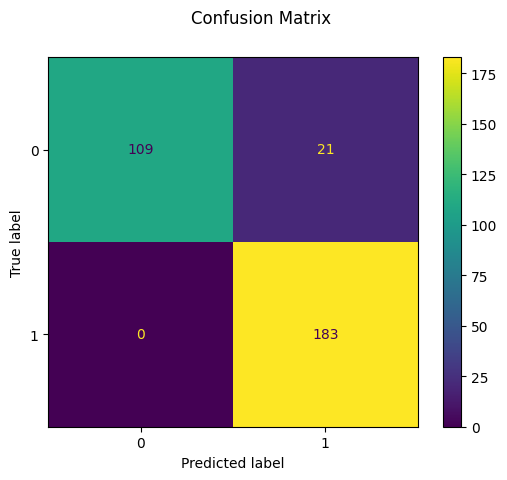

In [15]:
# Evaluating...
models["lof"]["metrics"] = test_model(models["lof"]["obj"], X_test_norm.values, y_test)

### 03.4. Isolation Forest (iForest)

In [16]:
# Fit iForest
models["iforest"]["obj"] = IsolationForestWrapper().fit(X_train_norm[y_train == 0].values)
# Save iForest object...
save_object(models["iforest"]["obj"], f"{BIN_PATH}iforest_obj")

#### Evaluate Model

Model Test: {'Precision': '86.32', 'Recall': '100.0', 'F1': '92.66', 'ROC_AUC': '88.85', 'Log_Loss': '3.3395'}



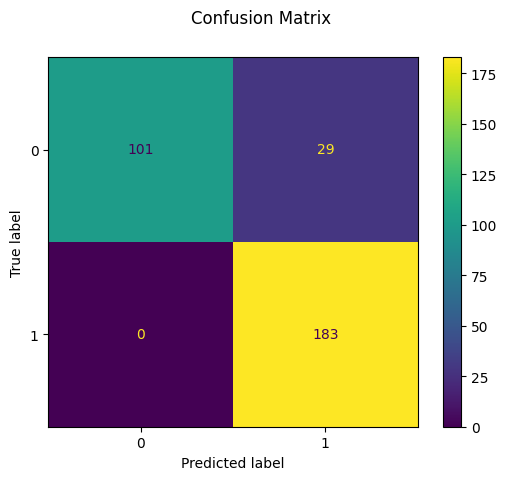

In [17]:
# Evaluating...
models["iforest"]["metrics"] = test_model(models["iforest"]["obj"], X_test_norm.values, y_test)

## 04. Model Comparative

In [18]:
# Compare models
results_df = pd.DataFrame([{**{'Modelo': key.upper()}, **value['metrics']} for key, value in models.items()])
# Results...
display(results_df)

,Modelo,Precision,Recall,F1,ROC_AUC,Log_Loss
0,AUTOENCODER,100.0,86.89,92.98,93.44,2.7637
1,OC_SVM,72.05,100.0,83.75,72.69,8.176
2,LOF,89.71,100.0,94.57,91.92,2.4183
3,IFOREST,86.32,100.0,92.66,88.85,3.3395
